In [3]:
import foolbox
import numpy as np
import torchvision.models as models

# instantiate model (supports PyTorch, Keras, TensorFlow (Graph and Eager), MXNet and many more)
model = models.resnet18(pretrained=True).eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=1000, preprocessing=preprocessing)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jafar/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [116]:
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

--2020-03-15 19:04:37--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.244.133
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.07s   

2020-03-15 19:04:37 (439 KB/s) - ‘imagenet1000_clsidx_to_labels.txt’ saved [30564/30564]



In [118]:
import json
name = 'imagenet1000_clsidx_to_labels.txt'
with open(name,'r') as f:
    txt = f.readlines()
    text = list(map(lambda x:x.replace("'","\""),txt))
labels_text = text

In [4]:

# get a batch of images and labels and print the accuracy
images, labels = foolbox.utils.samples(dataset='imagenet', batchsize=16, data_format='channels_first', bounds=(0, 1))
print(np.mean(fmodel.forward(images).argmax(axis=-1) == labels))
# -> 0.9375

0.9375


In [5]:


# apply the attack
attack = foolbox.attacks.FGSM(fmodel)
adversarials = attack(images, labels)
# if the i'th image is misclassfied without a perturbation, then adversarials[i] will be the same as images[i]
# if the attack fails to find an adversarial for the i'th image, then adversarials[i] will all be np.nan

# Foolbox guarantees that all returned adversarials are in fact in adversarials
print(np.mean(fmodel.forward(adversarials).argmax(axis=-1) == labels))
# -> 0.0


0.0


In [6]:


# ---

# In rare cases, it can happen that attacks return adversarials that are so close to the decision boundary,
# that they actually might end up on the other (correct) side if you pass them through the model again like
# above to get the adversarial class. This is because models are not numerically deterministic (on GPU, some
# operations such as `sum` are non-deterministic by default) and indepedent between samples (an input might
# be classified differently depending on the other inputs in the same batch).

# You can always get the actual adversarial class that was observed for that sample by Foolbox by
# passing `unpack=False` to get the actual `Adversarial` objects:
attack = foolbox.attacks.FGSM(fmodel, distance=foolbox.distances.Linf)
adversarials = attack(images, labels, unpack=False)

adversarial_classes = np.asarray([a.adversarial_class for a in adversarials])
print(labels)
print(adversarial_classes)
print(np.mean(adversarial_classes == labels))  # will always be 0.0


[243 559 438 990 949 853 609 609 915 455 541 630 741 471 129  99]
[242 694 711 937 927 706 479 511 672 539 463 636 497 870  89 138]
0.0


In [64]:
labels

array([243, 559, 438, 990, 949, 853, 609, 609, 915, 455, 541, 630, 741,
       471, 129,  99])

In [58]:
def transform_shape(img):
    shape = img[0].shape
    res = [[0 for i in range(shape[0])] for j in range(shape[1])]
    for i in range(shape[0]):
        for j in range(shape[1]):
            res[i][j] = [img[0][i][j], img[1][i][j], img[2][i][j]]
    return np.array(res)

In [134]:
adv = adversarials[8]
perturbed, original = adv.perturbed, adv.unperturbed
perturbed = transform_shape(perturbed)
original = transform_shape(original)

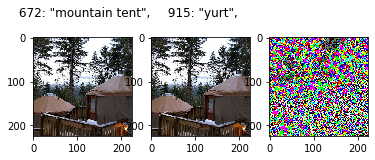

In [138]:
import matplotlib.pyplot as plt
plt.figure('FGSM')
plt.subplot(1,3,1)
plt.title(labels_text[adv.adversarial_class])
plt.imshow(perturbed)
plt.subplot(1,3,2)
plt.title(labels_text[adv.original_class])

plt.imshow(original)
plt.subplot(1,3,3)
difference = perturbed - original
maxi, mini = np.max(difference), np.min(difference)
difference = (difference - mini) / (maxi- mini)

#print(np.max(difference), np.min(difference))
plt.imshow(difference)

plt.savefig('FGSM')
plt.show()


In [137]:
ls

FGSM.ipynb  FGSM.png  imagenet1000_clsidx_to_labels.txt


In [139]:
!pwd

/home/jafar/PycharmProjects/strengthening-dnns/My Own Work


In [72]:

# The `Adversarial` objects also provide a `distance` attribute. Note that the distances
# can be 0 (misclassified without perturbation) and inf (attack failed).
distances = np.asarray([a.distance.value for a in adversarials])
print("{:.1e}, {:.1e}, {:.1e}".format(distances.min(), np.median(distances), distances.max()))
print("{} of {} attacks failed".format(sum(adv.distance.value == np.inf for adv in adversarials), len(adversarials)))
print("{} of {} inputs misclassified without perturbation".format(sum(adv.distance.value == 0 for adv in adversarials), len(adversarials)))


0.0e+00, 8.0e-04, 2.9e-03
0 of 16 attacks failed
1 of 16 inputs misclassified without perturbation


In [ ]:
!git add -A